This is a script where I do a sanity check of my pilot recording s1_sub01_AN.
I was mainly working with baseline (_BL) recordings as they are both short and have triggers.

**What was done?**

1. ANT eego format (.cnt) -> issues with reading the file.
2. Brainvision format (.eeg + .vhdr + .vmrk) -> all good, but there were concerns about loosing some events (impedance checks and amp reload triggers) + we wanted to use *zapline* for powerline (50 Hz + harmonics) filtering which gives a MemoryError when implemented in Python (*dss.dss_line()* from meegkit). Downsampling to 500Hz and transposing the data did not solve the issue. I tried to discuss it on the MNE forum, but did not come up with the solution in the end.
3. Used EEGLAB (Matlab) to apply zapline to the EEG data (.cnt), converted it to .set + .fdt first. Then imported the powerline filtered data to MNE using *mne.io.read_raw_eeglab()* function. -> **OPTIMAL SOLUTION**

**POWERLINE NOISE:** I compared PSD plots for notch_filter, prectrum_fit (multitaper) and zapline (EEGLAB) -> notch - dips at 50Hz and 100Hz; multitaper - better, but has a small bump at 50Hz, also not well described in the documentation; zapline - nice output. Raw.plots() looked comparable for all three options. Zapline is validated by the literature. **SOLUTION:** zapline.
References for this solution: 
    1.Original method: Cheveigné, A. de. ZapLine: A simple and effective method to remove power line artifacts. NeuroImage 207, 116356 (2020).
    2.Adaptation for EEGLAB: Klug, M. & Kloosterman, N. A. Zapline‐plus: A Zapline extension for automatic and adaptive removal of frequency‐specific noise artifacts in M/EEG. Hum. Brain Mapp. 43, 2743–2758 (2022).
  

I created dict to give the events names as in 'trigger_labels.txt' and original Matlab scripts with the tasks.
I also performed a sanity check for the number of events, trigger names and general look of the raw data.


**CONCLUSION**
**How to deal with the raw data?**
1. Export data from eego in .cnt format (*untick* Apply Montage) option
2. Import .cnt data into EEGLAB (Matlab) using *LoadCNT_Katya.m* script to downsample, apply zapline and convert it to .set + .fdt format
3. Import the powerline filtered data into MNE using *mne.io.read_raw_eeglab()*
4. Check the data for powerline noise and events
5. Proceed with the preprocessing


*NOTES*

*For more details refer to the email thread Preprocessing

**This script is for Katya's use only. It was created with the purpose of checking different data formats and powerline noise filtering options. It should not be uploaded to GitHub as a part of supplementary materials for the paper.

In [2]:
import mne
import numpy as np
import os
from utils import check_paths
import matplotlib.pyplot as plt

%matplotlib qt

**checking .cnt files**

In [ ]:
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data'
sub_name = 's1_sub01_AN'
eeg_data_path = os.path.join(eeg_data_dir, sub_name, 'cnt')
eeg_rest_oe = os.path.join(eeg_data_path, f'{sub_name}_RS_OE.cnt')
eeg_rest_ce = os.path.join(eeg_data_path, f'{sub_name}_RS_CE.cnt')
eeg_bl = os.path.join(eeg_data_path, f'{sub_name}_BL.cnt')
eeg_main = os.path.join(eeg_data_path, f'{sub_name}_MAIN.cnt')

In [ ]:
# rest_oe = mne.io.read_raw_cnt(eeg_rest_oe, eog=(), preload=True, data_format='int32')
rest_ce = mne.io.read_raw_cnt(eeg_rest_ce, preload=True)

UnicodeDecodeError: 'ascii' codec can't decode byte 0x8b in position 0: ordinal not in range(128)

**checking Brainvision files**

In [2]:
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data'
sub_name = 's1_sub01_AN'
eeg_data_path = os.path.join(eeg_data_dir, sub_name)
eeg_rest_oe = os.path.join(eeg_data_path, f'{sub_name}_RS_OE.vhdr')
eeg_rest_ce = os.path.join(eeg_data_path, f'{sub_name}_RS_CE.vhdr')
eeg_bl = os.path.join(eeg_data_path, f'{sub_name}_BL.vhdr')
eeg_main = os.path.join(eeg_data_path, f'{sub_name}_MAIN.vhdr')


In [8]:
os.listdir(eeg_data_path)

['s1_sub01_AN_BL.eeg',
 's1_sub01_AN_BL.vhdr',
 's1_sub01_AN_BL.vmrk',
 's1_sub01_AN_MAIN.eeg',
 's1_sub01_AN_MAIN.vhdr',
 's1_sub01_AN_MAIN.vmrk',
 's1_sub01_AN_RS_CE.eeg',
 's1_sub01_AN_RS_CE.vhdr',
 's1_sub01_AN_RS_CE.vmrk',
 's1_sub01_AN_RS_OE.eeg',
 's1_sub01_AN_RS_OE.vhdr',
 's1_sub01_AN_RS_OE.vmrk']

In [6]:
raw_bl = mne.io.read_raw_brainvision(eeg_bl, eog=(), preload=True)
raw_bl


Extracting parameters from D:\BonoKat\research project\# study 1\eeg_data\s1_sub01_AN\s1_sub01_AN_BL.vhdr...
Setting channel info structure...
Reading 0 ... 661707  =      0.000 ...   330.853 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_5944\2321917249.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_bl = mne.io.read_raw_brainvision(eeg_bl, eog=(), preload=True)


Measurement date,"May 09, 2024 13:11:06 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,63 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


Using matplotlib as 2D backend.


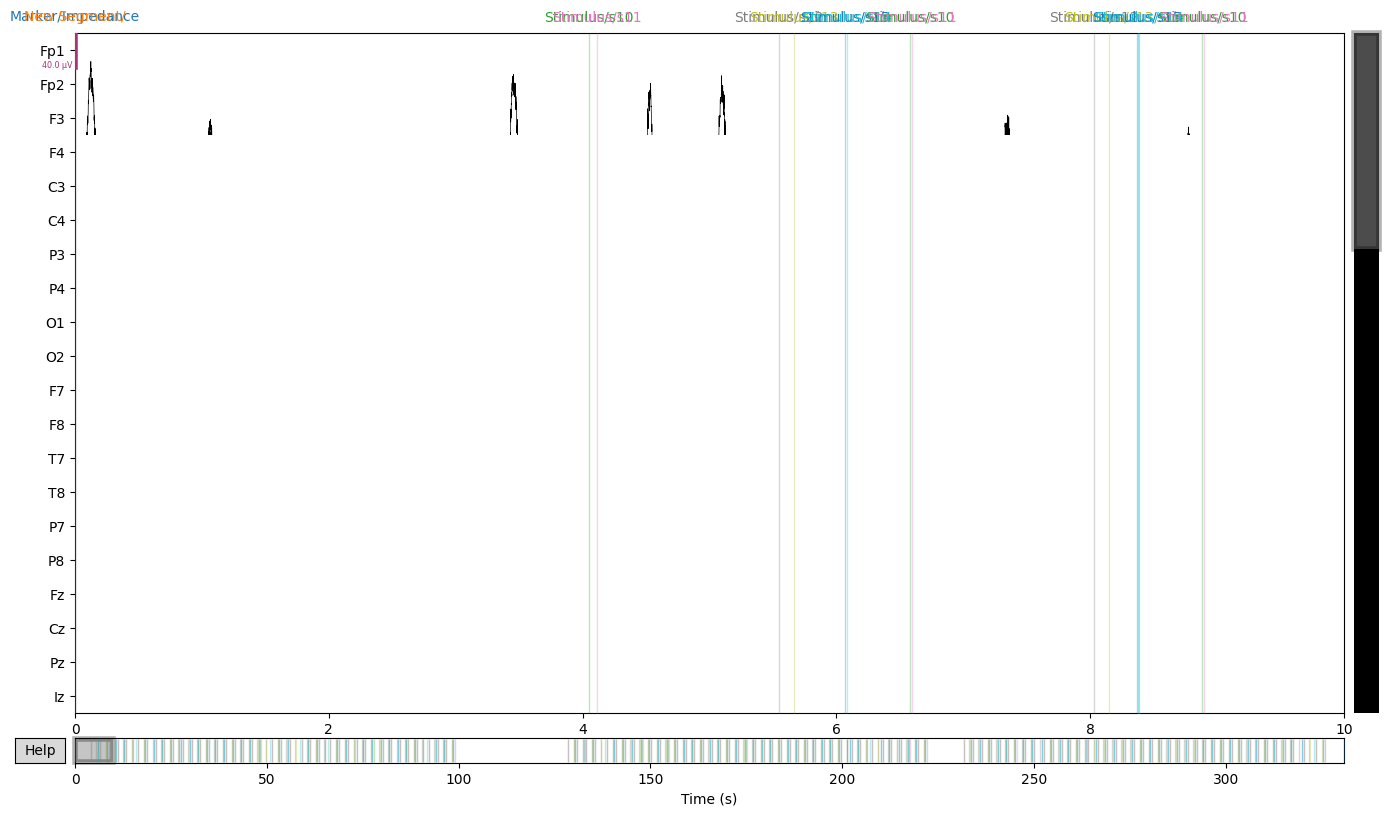

In [10]:
raw_bl.plot(remove_dc=False)

In [48]:
events_bl = mne.events_from_annotations(raw_bl)
events_bl

Used Annotations descriptions: ['Marker/Impedance', 'New Segment/', 'Stimulus/s10', 'Stimulus/s102', 'Stimulus/s103', 'Stimulus/s11', 'Stimulus/s12', 'Stimulus/s13', 'Stimulus/s14', 'Stimulus/s15']
Used Annotations descriptions: ['0, Impedance', '10', '102', '103', '11', '12', '13', '14', '15']


(array([[     0,      0,  10001],
        [     0,      0,  99999],
        [  8098,      0,  10002],
        ...,
        [650694,      0,  10008],
        [651727,      0,  10004],
        [661704,      0,  10001]]),
 {'Marker/Impedance': 10001,
  'New Segment/': 99999,
  'Stimulus/s10': 10002,
  'Stimulus/s102': 10003,
  'Stimulus/s103': 10004,
  'Stimulus/s11': 10005,
  'Stimulus/s12': 10006,
  'Stimulus/s13': 10007,
  'Stimulus/s14': 10008,
  'Stimulus/s15': 10009})

In [42]:
len(events_bl[0])

715

In [44]:
bl_count = []
for i in events_bl[0]:
    bl_count.append(i[0])
bl_count

[0,
 0,
 8098,
 8228,
 11095,
 11328,
 12128,
 12161,
 13163,
 13195,
 16061,
 16294,
 16741,
 16761,
 17763,
 17795,
 20661,
 20894,
 21302,
 21328,
 22331,
 22361,
 25228,
 25461,
 25746,
 25761,
 26763,
 26795,
 29661,
 29895,
 30088,
 31961,
 32965,
 32995,
 35861,
 36095,
 36519,
 36528,
 37529,
 37561,
 40428,
 41062,
 41094,
 42095,
 42128,
 44995,
 45228,
 45512,
 45528,
 46529,
 46561,
 49428,
 49661,
 49906,
 49928,
 50928,
 50961,
 53828,
 54061,
 54163,
 55082,
 55094,
 56095,
 56128,
 58994,
 59228,
 59734,
 59761,
 60762,
 60794,
 63662,
 63895,
 64148,
 64161,
 65162,
 65194,
 68061,
 68295,
 68644,
 68661,
 69662,
 69694,
 72561,
 72794,
 73210,
 73227,
 74228,
 74261,
 77128,
 77361,
 77733,
 77761,
 78762,
 78794,
 81661,
 81895,
 82181,
 82194,
 83195,
 83227,
 86095,
 86328,
 86627,
 86661,
 87661,
 87694,
 90561,
 90795,
 91099,
 91128,
 92128,
 92161,
 95028,
 95261,
 95687,
 95694,
 96695,
 96728,
 99595,
 99827,
 101894,
 102895,
 102928,
 105795,
 106028,
 1063

In [49]:
mne.count_events(events_bl[0], ids=None)

{10001: 2,
 10002: 119,
 10003: 2,
 10004: 1,
 10005: 119,
 10006: 119,
 10007: 115,
 10008: 120,
 10009: 117,
 99999: 1}

**checking notch and spectrum_fit (multitaper)**

In [ ]:
raw_bl_notch = raw_bl.copy().notch_filter(freqs=(50, 100))
raw_bl_multi = raw_bl.copy().notch_filter(freqs=(50, 100), method='spectrum_fit')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Removed notch frequencies (Hz):
     50.00 : 4095 windows
    100.00 : 4095 windows


NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 1.024 (s)


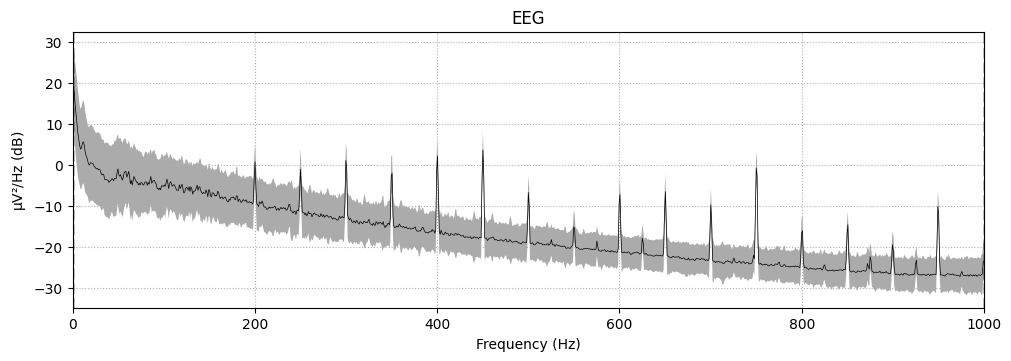

In [ ]:
mne.viz.plot_raw_psd(raw_bl_notch, average=True)

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 1.024 (s)


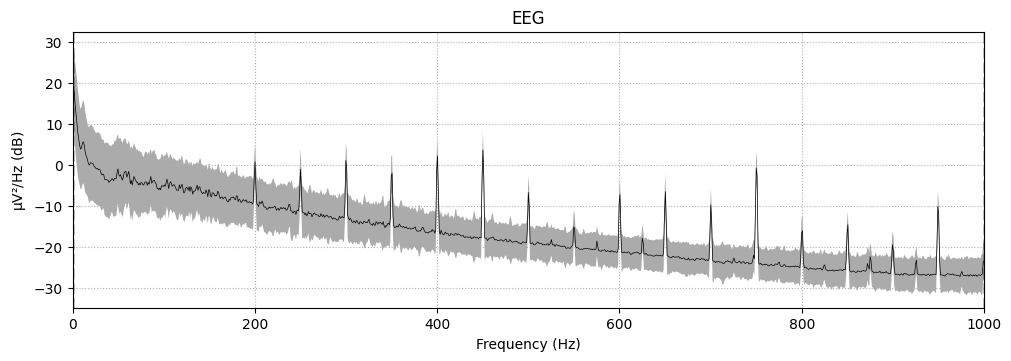

In [50]:
mne.viz.plot_raw_psd(raw_bl_multi, average=True)

Setting up band-pass filter from 1 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 1 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 80.00 Hz: -6.02, -6.02 dB



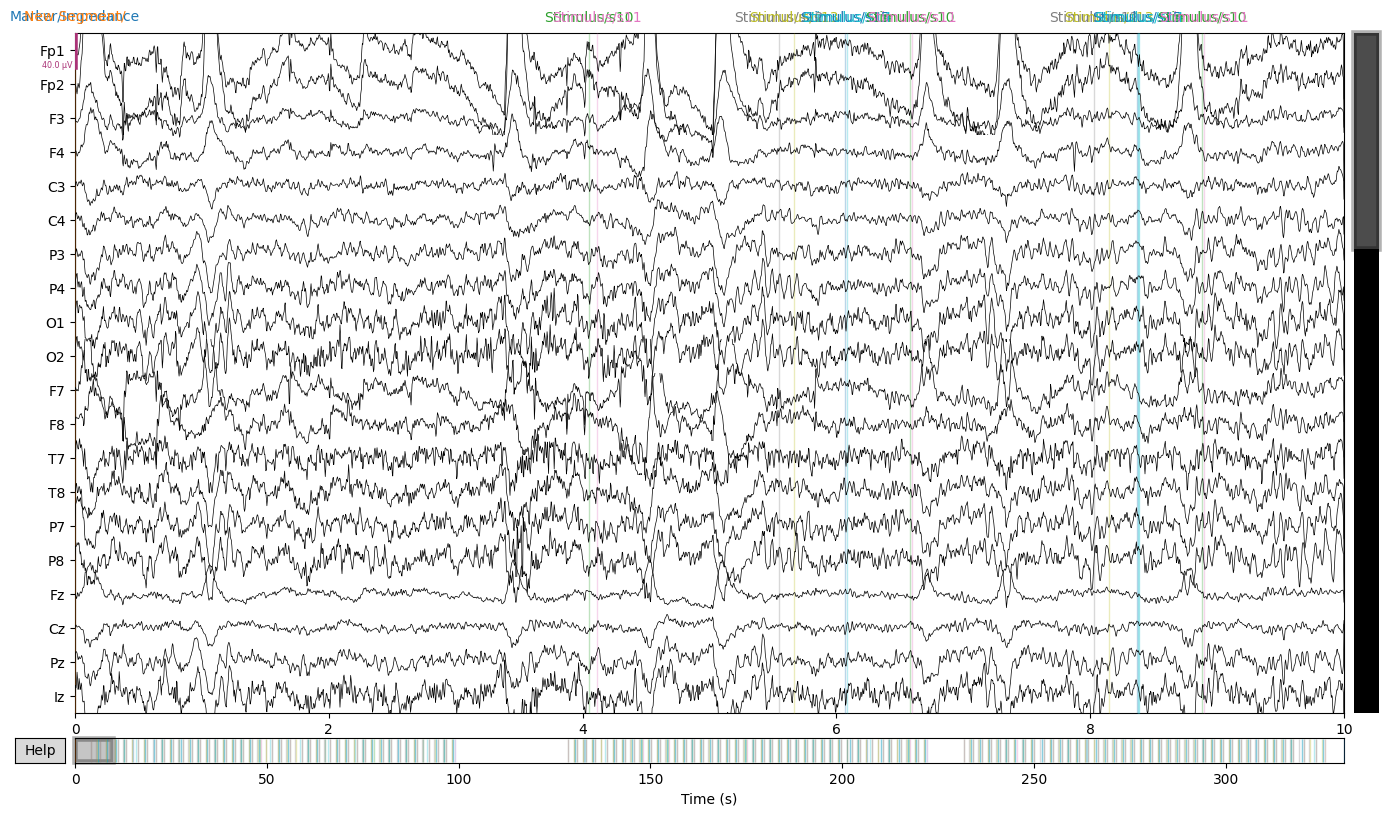

In [ ]:
raw_bl_notch.plot(highpass=1, lowpass=80)
raw_bl_multi.plot(highpass=1, lowpass=80)

**checking zapline with meegkit**

In [ ]:
raw_bl = mne.io.read_raw_brainvision(eeg_bl, eog=(), preload=True)
raw_bl

Extracting parameters from D:\BonoKat\research project\# study 1\eeg_data\s1_sub01_AN\s1_sub01_AN_BL.vhdr...
Setting channel info structure...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_1492\3764465094.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_bl = mne.io.read_raw_brainvision(eeg_bl, eog=())


Measurement date,"May 09, 2024 13:11:06 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,63 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


In [ ]:
events = mne.events_from_annotations(raw_bl)
events

Used Annotations descriptions: ['Marker/Impedance', 'New Segment/', 'Stimulus/s10', 'Stimulus/s102', 'Stimulus/s103', 'Stimulus/s11', 'Stimulus/s12', 'Stimulus/s13', 'Stimulus/s14', 'Stimulus/s15']


(array([[     0,      0,  10001],
        [     0,      0,  99999],
        [  8098,      0,  10002],
        ...,
        [650694,      0,  10008],
        [651727,      0,  10004],
        [661704,      0,  10001]]),
 {'Marker/Impedance': 10001,
  'New Segment/': 99999,
  'Stimulus/s10': 10002,
  'Stimulus/s102': 10003,
  'Stimulus/s103': 10004,
  'Stimulus/s11': 10005,
  'Stimulus/s12': 10006,
  'Stimulus/s13': 10007,
  'Stimulus/s14': 10008,
  'Stimulus/s15': 10009})

In [ ]:
raw_downsampled, new_events = raw_bl.copy().resample(sfreq=500, events=events[0])

In [ ]:
from scipy import signal
from meegkit import dss
from meegkit.utils import create_line_data, unfold

In [ ]:
cleaned_raw = zapline_clean(raw_bl, 50)

In [ ]:
data = raw_bl.get_data() # Convert mne data to numpy darray
sfreq = raw_bl.info['sfreq'] # Extract the sampling freq

#Apply MEEGkit toolbox function
out, _ = dss.dss_line(data, 50, sfreq, nremove=4) # fline (Line noise freq) = 50 Hz for Europe

cleaned_raw = mne.io.RawArray(out, raw_bl.info) # Convert output to mne RawArray again

Reducing nfft to 63


MemoryError: Unable to allocate 3.19 TiB for an array with shape (661708, 661708) and data type float64

**checking the .set file**

In [5]:
filepath = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\s1_sub01_AN\\set\\s1_sub01_AN_MAIN.set'
raw_set = mne.io.read_raw_eeglab(filepath, preload=True)

Reading D:\BonoKat\research project\# study 1\eeg_data\s1_sub01_AN\set\s1_sub01_AN_MAIN.fdt
Reading 0 ... 8240996  =      0.000 ...  4120.498 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_29808\4127197318.py:2: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw_set = mne.io.read_raw_eeglab(filepath, preload=True)


In [40]:
raw_set

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,66 points
Good channels,63 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


In [6]:
events_set = mne.events_from_annotations(raw_set)
events_set

Used Annotations descriptions: ['0, Impedance', '111', '2', '20', '3', '30', '4', '40', '5', '6', '7', '77', '8', '9']


(array([[      0,       0,       1],
        [   2667,       0,       4],
        [   4167,       0,       2],
        ...,
        [8222911,       0,       6],
        [8225748,       0,      14],
        [8240994,       0,       1]]),
 {'0, Impedance': 1,
  '111': 2,
  '2': 3,
  '20': 4,
  '3': 5,
  '30': 6,
  '4': 7,
  '40': 8,
  '5': 9,
  '6': 10,
  '7': 11,
  '77': 12,
  '8': 13,
  '9': 14})

In [ ]:
mne.count_events(events_set[0], ids=None)

{1: 2, 2: 119, 3: 2, 4: 1, 5: 119, 6: 119, 7: 115, 8: 120, 9: 117}

In [ ]:
len(events_set[0])

714

In [ ]:
set_count = []
for i in events_set[0]:
    set_count.append(i[0])
set_count

[0,
 8099,
 8229,
 11096,
 11328,
 12129,
 12162,
 13164,
 13196,
 16062,
 16295,
 16742,
 16762,
 17764,
 17796,
 20662,
 20894,
 21303,
 21328,
 22332,
 22361,
 25229,
 25462,
 25747,
 25762,
 26763,
 26795,
 29662,
 29896,
 30089,
 31962,
 32965,
 32995,
 35861,
 36096,
 36519,
 36529,
 37530,
 37562,
 40428,
 41063,
 41095,
 42096,
 42129,
 44996,
 45229,
 45513,
 45529,
 46530,
 46562,
 49429,
 49662,
 49907,
 49929,
 50929,
 50962,
 53828,
 54062,
 54164,
 55083,
 55095,
 56096,
 56129,
 58995,
 59229,
 59735,
 59762,
 60763,
 60795,
 63663,
 63896,
 64149,
 64162,
 65163,
 65195,
 68062,
 68296,
 68644,
 68662,
 69663,
 69695,
 72562,
 72795,
 73211,
 73228,
 74229,
 74262,
 77129,
 77361,
 77734,
 77762,
 78763,
 78795,
 81661,
 81895,
 82181,
 82194,
 83196,
 83228,
 86096,
 86329,
 86628,
 86661,
 87661,
 87694,
 90562,
 90796,
 91100,
 91129,
 92129,
 92162,
 95029,
 95262,
 95688,
 95695,
 96696,
 96729,
 99596,
 99828,
 101894,
 102896,
 102929,
 105796,
 106029,
 106357,


Setting up band-pass filter from 1 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 80.00 Hz: -6.02, -6.02 dB



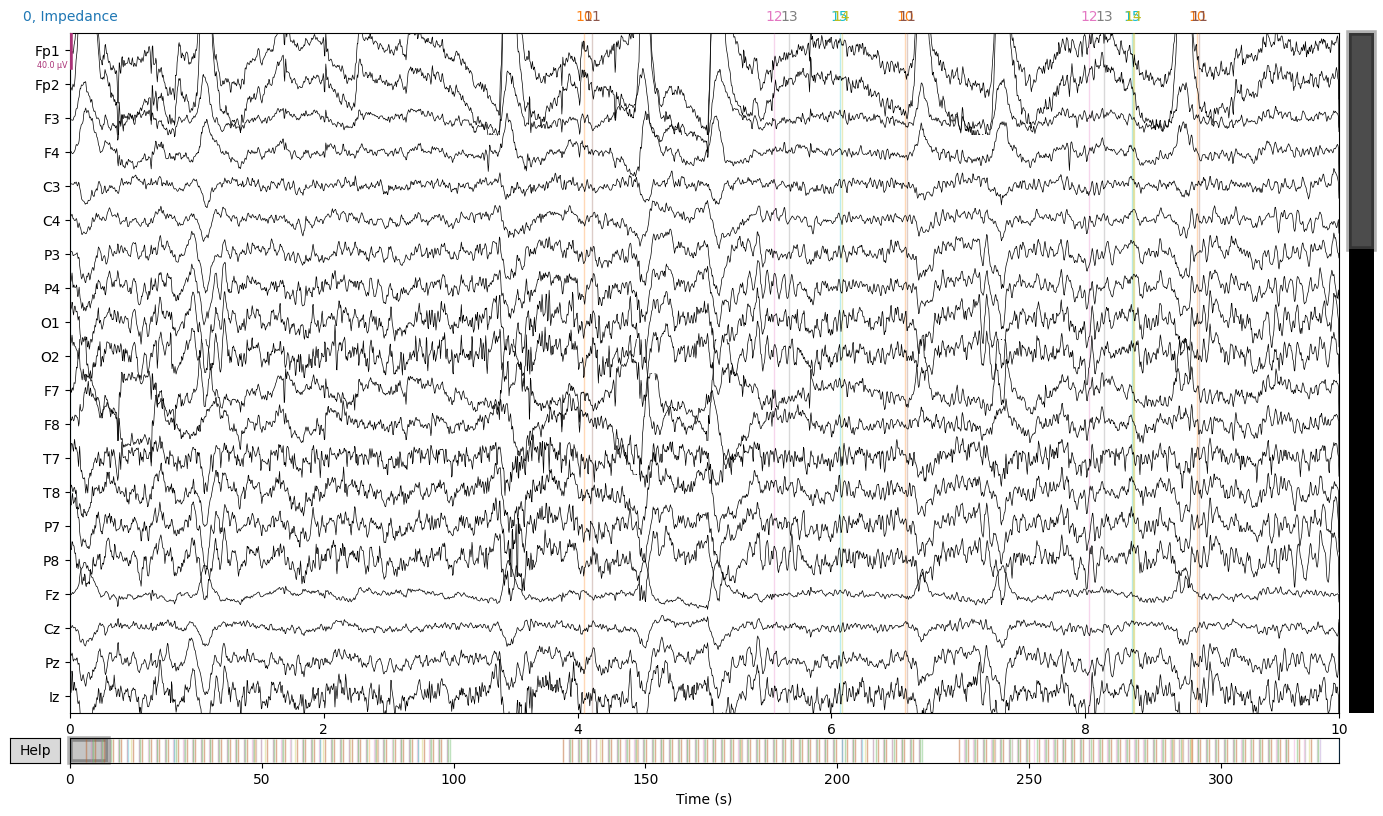

In [20]:
raw_set.plot(highpass=1, lowpass=80)

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 1.024 (s)


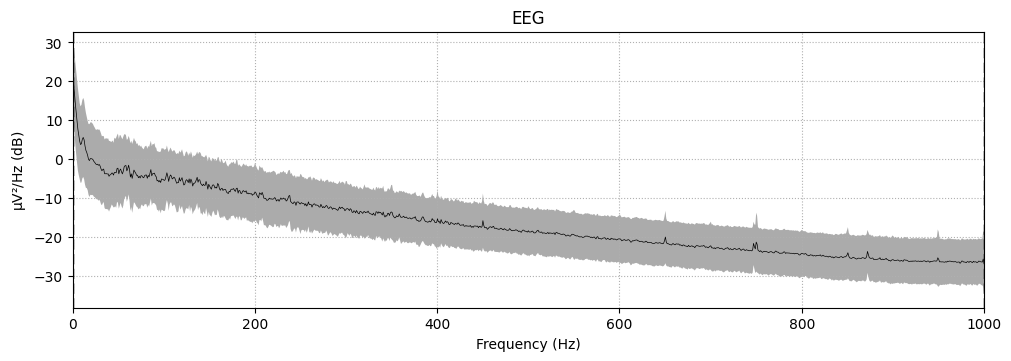

In [16]:
mne.viz.plot_raw_psd(raw_set, average=True)
